In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

In [4]:
import numpy as np 
import pandas as pd 
import fastai.tabular.all as ft
import torch 
import torch.nn as nn
import torch.nn.functional as F

- Ejercicio 1: Agrega información de año y mes, y agrega el EWMA también. 

- Repite todo a ver si llegas a menos.

- Ejercicio 2: Repite esto con alguna otra serie de tiempo, como la de macrodata.csv y agrega la información producida por Hodrick-Prescott o Holt Winters. Entrena de nuevo. ¿Mejoró?

In [5]:
df = pd.read_csv('/content/daily-min-temperatures.csv', index_col='Date', parse_dates=True)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Agrega información de año y mes, y agrega el EWMA también

In [7]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['EWMA'] = df['Temp'].ewm(alpha=0.5).mean()
df.head()

,Temp,Year,Month,EWMA
Date,,,,
1981-01-01,20.7,1981,1,20.700000
1981-01-02,17.9,1981,1,18.833333
1981-01-03,18.8,1981,1,18.814286
1981-01-04,14.6,1981,1,16.566667
1981-01-05,15.8,1981,1,16.170968


In [19]:
def L1_error(df_temp,df_prev_temp): 
  
  return np.mean(np.abs(df_temp-df_prev_temp))

def RMSE_error(df_temp,df_prev_temp):
  return np.sqrt(np.mean(np.square(df_temp-df_prev_temp)))

Calculamos la temperatura previa


In [23]:
df["prev_temp"] = df["Temp"].shift(1)
df.dropna(inplace=True)
df.head()

,Temp,Year,Month,EWMA,prev_temp
Date,,,,,
1981-01-02,17.9,1981,1,18.833333,20.7
1981-01-03,18.8,1981,1,18.814286,17.9
1981-01-04,14.6,1981,1,16.566667,18.8
1981-01-05,15.8,1981,1,16.170968,14.6
1981-01-06,15.8,1981,1,15.982540,15.8


In [24]:
print('Error L1: ',L1_error(df.iloc[-365:]['Temp'], df.iloc[-365:]['prev_temp']))
print('Error RMSE: ',RMSE_error(df.iloc[-365:]['Temp'], df.iloc[-365:]['prev_temp']))

Error L1:  2.0249315068493146
Error RMSE:  2.5824009217292243


In [26]:
def load_data(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - 365
  src = ft.TabularPandas(df,cont_names=list(df.columns[1:]), y_names=['Temp'], 
                         splits = (X[:valid_cut], X[valid_cut:])) 
  return src.dataloaders(bs=1024)

In [27]:
dls = load_data(df)

In [28]:
def RMSE_loss(pred, targ): 
  return torch.sqrt(F.mse_loss(pred, targ))

In [29]:
#Sin capas intermedias
learn = ft.tabular_learner(dls, layers=[], metrics=[F.l1_loss, RMSE_loss])
learn.fit_one_cycle(25, 1e-1)

epoch,train_loss,valid_loss,l1_loss,RMSE_loss,time
0,141.961243,102975.453125,320.877106,320.897888,00:00
1,140.842682,29050.777344,170.405869,170.442886,00:00
2,139.266296,12710.288086,112.689964,112.739922,00:00
3,136.546906,7260.222656,85.150887,85.206940,00:00
4,132.373367,3413.945312,58.364288,58.428974,00:00
5,125.322533,553.928467,23.418276,23.535683,00:00
6,114.699486,159.983231,12.441528,12.648448,00:00
7,101.587753,232.384018,14.999479,15.244146,00:00
8,88.793434,13.458831,3.023338,3.668628,00:00
9,78.615982,41.671246,6.046477,6.455327,00:00


SuggestedLRs(valley=0.00363078061491251)

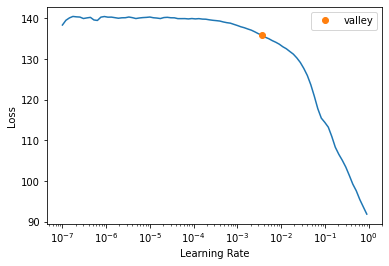

In [31]:
# Con capaz intermedias
learn = ft.tabular_learner(dls, layers=[64, 128], metrics=[F.l1_loss, RMSE_loss])
learn.lr_find()

In [32]:
learn.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,l1_loss,RMSE_loss,time
0,140.265976,625.105347,24.710226,25.002108,00:00
1,140.135956,588.088440,23.953857,24.250536,00:00
2,139.505020,681.814880,25.844229,26.111586,00:00
3,138.318283,886.671753,29.557684,29.777037,00:00
4,136.975815,1204.886353,34.542336,34.711472,00:00
5,135.734543,1576.105835,39.574268,39.700199,00:00
6,134.221207,1822.968140,42.598709,42.696232,00:00
7,132.806442,1824.906372,42.641804,42.718922,00:00
8,131.454071,1626.312012,40.264469,40.327560,00:00
9,130.231003,1317.973267,36.250652,36.303902,00:00


In [33]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=4, out_features=64, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=64, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [34]:
# Haciendo cambios en las funciones de activación 
learn.model.layers[0][2] = nn.LeakyReLU(inplace=True)
learn.model.layers[1][2] = nn.LeakyReLU(inplace=True)

In [36]:
learn = ft.tabular_learner(dls, layers=[128, 64], metrics=[RMSE_loss, F.l1_loss])
learn.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,RMSE_loss,l1_loss,time
0,140.423630,102.983559,10.148082,9.418327,00:00
1,140.565201,111.521896,10.560392,9.885297,00:00
2,139.886551,115.221275,10.734118,10.111499,00:00
3,138.898956,105.858490,10.288755,9.696726,00:00
4,137.521805,75.635849,8.696887,8.092132,00:00
5,135.972717,35.250000,5.937171,5.232770,00:00
6,134.638077,17.243135,4.152485,3.483324,00:00
7,133.555634,12.679348,3.560807,2.939727,00:00
8,132.442627,14.783363,3.844914,3.311707,00:00
9,131.552505,21.430380,4.629296,4.244517,00:00


## Repite esto con alguna otra serie de tiempo, como la de macrodata.csv y agrega la información producida por Hodrick-Prescott o Holt Winters. Entrena de nuevo. ¿Mejoró?

In [38]:
df = pd.read_csv('macrodata.csv', index_col='Unnamed: 0', parse_dates=True)
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


---
Debido a que el dataset ya cuenta con la columna 'year', únicamente agregamos el mes. 

In [40]:
df['month'] = df.index.month
df['EWMA'] = df['realgdp'].ewm(alpha=0.5).mean()
df["prev_realgdp"] = df["realgdp"].shift(1)
df.dropna(inplace=True)
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,month,EWMA,prev_realgdp
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,6,2755.983667,2710.349
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,9,2767.129000,2778.801
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,12,2776.769000,2775.488
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,3,2813.378032,2785.204
1960-06-30,1960,2,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55,6,2824.050778,2847.699


In [41]:
print('Error L1: ',L1_error(df.iloc[-365:]['realgdp'], df.iloc[-365:]['prev_realgdp']))
print('Error RMSE: ',RMSE_error(df.iloc[-365:]['realgdp'], df.iloc[-365:]['prev_realgdp']))

Error L1:  64.89782178217823
Error RMSE:  78.57843513816226


In [44]:
def cargar_datos(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - 41
  #print(valid_cut)
  src = ft.TabularPandas(df,
                         cont_names=list(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'realint',
       'month', 'EWMA', 'ult_realgdp']), 
                         y_names=['realgdp'],
                        splits = (X[:valid_cut], X[valid_cut:])) 
  return src.dataloaders(bs=12)

In [ ]:
dls = cargar_datos(df)

In [ ]:
def RMSE_loss(pred, targ): 
  return torch.sqrt(F.mse_loss(pred, targ))

SuggestedLRs(valley=0.0831763744354248)

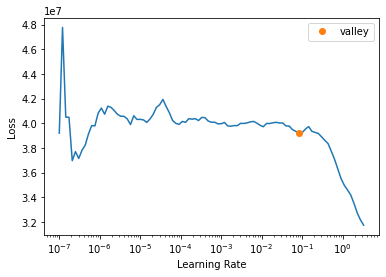

In [ ]:
# Con capaz intermedias
learn = ft.tabular_learner(dls, layers=[256, 128], metrics=[F.l1_loss, RMSE_loss])
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, 1e-1)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,40343928.000000,148892304.000000,12175.776367,12178.471680,00:00
1,40382340.000000,148052608.000000,12141.621094,12144.291016,00:00
2,40368044.000000,145692192.000000,12044.249023,12046.901367,00:00
3,39759764.000000,138620336.000000,11747.060547,11749.754883,00:00
4,38765020.000000,112729104.000000,10591.988281,10594.488281,00:00
5,36417184.000000,60458564.000000,7753.518066,7755.728027,00:00
6,31810222.000000,6038717.500000,2442.723145,2444.264160,00:00
7,25714974.000000,4788200.000000,1870.880737,1915.008423,00:00
8,19552742.000000,2229837.250000,1287.485107,1319.582886,00:00
9,14789580.000000,2557937.250000,1346.014160,1380.043091,00:00


In [46]:
import statsmodels as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [47]:
temp_trend, temp_cycle = hpfilter(df['realgdp'], lamb=6.25)

In [48]:
df['temp_cycle'] = temp_cycle
df['temp_trend'] = temp_trend

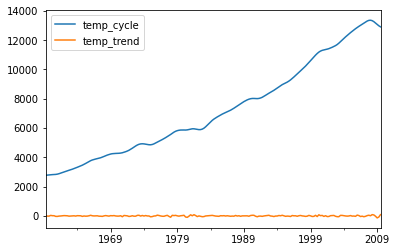

In [49]:
df[['temp_cycle', 'temp_trend']].plot()

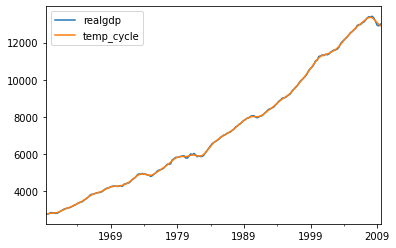

In [50]:
df[['realgdp', 'temp_cycle']].plot()

In [51]:
def Load_data_HP(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - 41
  #print(valid_cut)
  src = ft.TabularPandas(df,
                         cont_names=list(['year', 'quarter', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint',
       'month', 'EWMA', 'ult_realgdp', 'temp_cycle', 'temp_trend']), # Tomate estas columnas
                         y_names=['realgdp'], # Para predecir esta
                        splits = (X[:valid_cut], X[valid_cut:])) # primeros para entrerar, últimos para validar
  return src.dataloaders(bs=12)

In [ ]:
dls = Load_data_HP(df)

SuggestedLRs(valley=0.2089296132326126)

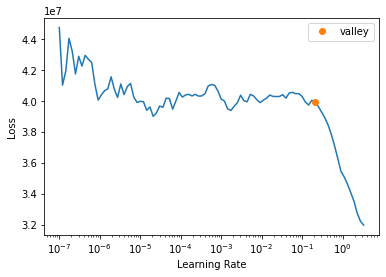

In [ ]:
learn = ft.tabular_learner(dls, layers=[256, 128], metrics=[F.l1_loss, rmse_loss])
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,40725248.000000,149038368.000000,12181.784180,12184.477539,00:00
1,39910424.000000,148062976.000000,12142.098633,12144.752930,00:00
2,39743652.000000,144502704.000000,11995.465820,11998.083984,00:00
3,39601588.000000,133237920.000000,11518.738281,11521.248047,00:00
4,38641680.000000,113450536.000000,10621.522461,10624.698242,00:00
5,36208852.000000,40136768.000000,6323.717773,6324.951660,00:00
6,31783858.000000,9705945.000000,3103.209229,3105.322998,00:00
7,25653866.000000,420546.281250,622.403809,633.485596,00:00
8,19675366.000000,3561351.000000,1864.533325,1867.016602,00:00
9,14964894.000000,146099.921875,346.399017,357.159027,00:00


## ¿Mejoró?
Sí